# **Instalamos las librerias necesarias**

In [1]:
%%capture
! pip install ase pubchempy nglview==3.0.1 "ipywidgets>=7.6.0,<8"
! curl -LJO https://raw.githubusercontent.com/emartineznunez/Master_Quimica/master/Google_colab/FA.xyz
! curl -LJO https://raw.githubusercontent.com/emartineznunez/Master_Quimica/master/network_NH2Level2.html
! curl -LJO https://raw.githubusercontent.com/emartineznunez/Master_Quimica/master/.local/bin/mopac
! curl -LJO https://raw.githubusercontent.com/emartineznunez/Master_Quimica/master/lib/libiomp5.so
! curl -LJO https://raw.githubusercontent.com/emartineznunez/AutoMeKin/main/scripts/mopacamk.py


In [2]:
%%capture
%env PATH="/content:.:/opt/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin"
%env LD_LIBRARY_PATH="/content:/usr/local/nvidia/lib:/usr/local/nvidia/lib64"
!chmod +x mopac

# **Visualización de moléculas**

In [3]:
from google.colab import output
output.enable_custom_widget_manager()

In [4]:
#The database is here: https://wiki.fysik.dtu.dk/ase/ase/build/build.html
from ase.build import molecule
from ase.visualize import view

water = molecule('H2O')
FA = molecule('HCOOH')
C60 = molecule('C60')
cyclobutene = molecule('cyclobutene')
view(water, viewer='x3d')

In [5]:
view(FA, viewer='x3d')

In [6]:
view(C60, viewer='x3d')

In [7]:
view(cyclobutene, viewer='x3d')

In [8]:
from ase.build import graphene_nanoribbon
from ase.visualize import view

gnr1 = graphene_nanoribbon(3, 4, type='armchair', saturated=True,
                               vacuum=3.5)
gnr2 = graphene_nanoribbon(2, 6, type='zigzag', saturated=True,
                           C_H=1.1, C_C=1.4, vacuum=3.0,
                           magnetic=True, initial_mag=1.12)
view(gnr1, viewer='x3d')

In [9]:
view(gnr2, viewer='x3d')

In [10]:
from ase.build import nanotube
from ase.visualize import view
from ase.io import write

cnt1 = nanotube(6, 0, length=4)
cnt2 = nanotube(3, 3, length=6, bond=1.4, symbol='Si')

view(cnt1, viewer='x3d')

In [11]:
view(cnt2, viewer='x3d')

In [12]:
from ase.build import fcc111
from ase.visualize import view
from ase.io import write

#https://wiki.fysik.dtu.dk/ase/ase/build/surface.html?highlight=fcc111#ase.build.fcc111

slab = fcc111('Al', size=(3,3,2))
view(slab,viewer='x3d')

In [13]:
# ontop,fcc,bridge,hcp

# https://wiki.fysik.dtu.dk/ase/ase/build/surface.html?highlight=fcc111#ase.build.fcc111

from ase.build import fcc111,add_adsorbate
from ase.visualize import view
from ase.io import write

slab = fcc111('Al', size=(3,3,2))
add_adsorbate(slab,'H',1.5,'hcp')

view(slab,viewer='x3d')

In [15]:
#Aqui puedes visualizar cualquier molecula tomada de https://pubchem.ncbi.nlm.nih.gov/

import pubchempy as pcp
from ase.io import read
#Building the molecule

#The default is formic acid, but you might want another one https://pubchem.ncbi.nlm.nih.gov/
sel = input('This example is for \'formic acid\'.Do you want to choose your own molecule (y/n)?: ')
if sel == 'n':
  molecule = 'formic acid'
  nm = 'name'
else:
  nm = input('Identifier type: cid, name, smiles, sdf, inchi, inchikey, or formula: ')
  molecule = input('Type your molecule here: ')

query = pcp.get_compounds(molecule,nm,record_type='3d')
m = query[0]
f = open('mol.xyz','w')
f.write(str(len(m.atoms)) + '\n\n')
for i,a in enumerate(m.atoms): f.write(m.elements[i]+' '+str(a.x)+' '+str(a.y)+' '+str(a.z)+'\n')
f.close()

atoms = read('mol.xyz')
view(atoms,viewer='x3d')

This example is for 'formic acid'.Do you want to choose your own molecule (y/n)?: n


# **Optimización**

In [16]:
#with the Powershell prompt
#cd Desktop
# ase gui H2O.traj
# show forces, bonds
from ase import Atoms
from ase.units import kJ,mol
from ase.build import molecule
from ase.optimize import BFGS, FIRE
from ase.calculators.emt import EMT
from ase.io import read
from ase.visualize import view
import numpy as np
import warnings
warnings.filterwarnings("ignore")

n2 = molecule('N2')

mu = n2.get_masses()[0] / 2 / mol * 0.001

natoms = len(n2)

n2.set_calculator(EMT())
dyn = BFGS(n2, trajectory='N2.traj')
dyn.run(fmax=0.001)

delta=0.001

n2.positions[0][2] = n2.get_positions()[0][2] + delta
g1 = abs(n2.get_forces()[0][2])

frec = 1 / (2 * np.pi) * np.sqrt(g1/delta / kJ * 1000 / mu) / 2.9979

print('Vibrational frequency (cm-1):',frec)

      Step     Time          Energy          fmax
BFGS:    0 19:18:18        0.548765        3.964835
BFGS:    1 19:18:18        0.269415        0.702390
BFGS:    2 19:18:18        0.263420        0.225843
BFGS:    3 19:18:18        0.262778        0.008377
BFGS:    4 19:18:18        0.262777        0.000095
Vibrational frequency (cm-1): 1231.5086336971679


In [17]:
from ase import *
from ase.units import kB
from ase.optimize import LBFGS
from ase.calculators.emt import EMT
from ase.optimize.basin import BasinHopping
import numpy as np

d = 0.9575
t = np.pi / 180 * 104.51
water = Atoms('H2O',
              positions=[(d, 0, 0),
                         (d * np.cos(t), d * np.sin(t), 0),
                         (0, 0, 0)],
              calculator=EMT())

bh = BasinHopping(atoms=water,         # the system to optimize
                  temperature=100 * kB, # 'temperature' to overcome barriers
                  dr=0.5,               # maximal stepwidth
                  optimizer=LBFGS,      # optimizer to find local minima
                  fmax=0.1,             # maximal force for the optimizer
                  )

       Step     Time          Energy          fmax
LBFGS:    0 19:18:22        2.769632        8.609090
LBFGS:    1 19:18:22        1.930507        1.641499
LBFGS:    2 19:18:22        1.884227        0.535354
LBFGS:    3 19:18:22        1.879314        0.049628
BasinHopping: step -1, energy        1.879314, emin        1.879314


In [18]:
#with the Powershell prompt
#cd Desktop
# ase gui H2O.traj
# show forces, bonds
from ase import Atoms
from ase.optimize import BFGS, FIRE
from ase.calculators.emt import EMT
from ase.io import read
from ase.visualize import view
import numpy as np
import warnings
warnings.filterwarnings("ignore")
d = 0.9575
t = np.pi / 180 * 104.51
water = Atoms('H2O',
              positions=[(d, 0, 0),
                         (d * np.cos(t), d * np.sin(t), 0),
                         (0, 0, 0)],
              calculator=EMT())
dyn = BFGS(water, trajectory='H2O.traj')
dyn.run(fmax=0.05)


      Step     Time          Energy          fmax
BFGS:    0 19:18:27        2.769632        8.609090
BFGS:    1 19:18:27        1.930507        1.641499
BFGS:    2 19:18:27        1.884227        0.535354
BFGS:    3 19:18:27        1.879314        0.049628


True

In [19]:
# Test using mopac

from ase import Atoms
from ase.build import molecule
from ase.optimize import BFGS, FIRE
from ase.calculators.emt import EMT
from mopacamk import MOPACamk
from ase.io import read
from ase.visualize import view
import numpy as np
import warnings
warnings.filterwarnings("ignore")

#Method 1: read xyz file
FA = read('FA.xyz')
FA.calc = MOPACamk()

#Method 2: construct molecule with Atoms
d = 0.9575
t = np.pi / 180 * 104.51
water = Atoms('H2O',
              positions=[(d, 0, 0),
                         (d * np.cos(t), d * np.sin(t), 0),
                         (0, 0, 0)],
              calculator=EMT())


#Method 3: get the molecule from database
AcH = molecule('CH3COOH',calculator=EMT())

#Change the name of the sysmte below
dyn = BFGS(FA, trajectory='H2O.traj')

dyn.run(fmax=0.05)

      Step     Time          Energy          fmax
BFGS:    0 19:18:31     -740.165090        2.226556
BFGS:    1 19:18:31     -740.198860        3.279809
BFGS:    2 19:18:31     -740.261060        0.788661
BFGS:    3 19:18:31     -740.274450        0.439460
BFGS:    4 19:18:31     -740.289050        0.211294
BFGS:    5 19:18:31     -740.290170        0.098450
BFGS:    6 19:18:31     -740.290380        0.040982


True

# **Termoquímica**
https://wiki.fysik.dtu.dk/ase/ase/thermochemistry/thermochemistry.html

In [20]:
from ase.build import molecule
from ase.calculators.emt import EMT
from ase.optimize import QuasiNewton
from ase.vibrations import Vibrations
from ase.thermochemistry import IdealGasThermo

atoms = molecule('NH3')
atoms.set_calculator(EMT())
dyn = QuasiNewton(atoms)
dyn.run(fmax=0.01)
potentialenergy = atoms.get_potential_energy()

vib = Vibrations(atoms)
vib.run()
vib_energies = vib.get_energies()
vib.clean()

thermo = IdealGasThermo(vib_energies=vib_energies,
                        potentialenergy=potentialenergy,
                        atoms=atoms,
                        geometry='nonlinear',
                        symmetrynumber=3, spin=0)
G = thermo.get_gibbs_energy(temperature=298.15, pressure=101325.)

                Step[ FC]     Time          Energy          fmax
BFGSLineSearch:    0[  0] 19:18:34        3.366507       6.4408
BFGSLineSearch:    1[  2] 19:18:35        2.333164       0.0154
BFGSLineSearch:    2[  5] 19:18:35        2.332916       0.0809
BFGSLineSearch:    3[  7] 19:18:35        2.332016       0.0183
BFGSLineSearch:    4[  8] 19:18:35        2.331903       0.0402
BFGSLineSearch:    5[ 10] 19:18:35        2.331868       0.0001
Enthalpy components at T = 298.15 K:
E_pot                  2.332 eV
E_ZPE                  0.516 eV
Cv_trans (0->T)        0.039 eV
Cv_rot (0->T)          0.039 eV
Cv_vib (0->T)          0.044 eV
(C_v -> C_p)           0.026 eV
-------------------------------
H                      2.995 eV

Entropy components at T = 298.15 K and P = 101325.0 Pa:
                           S               T*S
S_trans (1 bar)    0.0014947 eV/K        0.446 eV
S_rot              0.0005287 eV/K        0.158 eV
S_elec             0.0000000 eV/K        0.000 eV
S_vi

# **Energías de disociación**

In [21]:
from ase import Atoms
from ase.calculators.emt import EMT

atom = Atoms('N', calculator=EMT())
e_atom = atom.get_potential_energy()

d = 1.1
molecule = Atoms('2N', [(0., 0., 0.), (0., 0., d)])
molecule.set_calculator(EMT())
e_molecule = molecule.get_potential_energy()

e_atomization = e_molecule - 2 * e_atom

print('Nitrogen atom energy: %5.2f eV' % e_atom)
print('Nitrogen molecule energy: %5.2f eV' % e_molecule)
print('Dissociation energy: %5.2f eV' % -e_atomization)

Nitrogen atom energy:  5.10 eV
Nitrogen molecule energy:  0.44 eV
Dissociation energy:  9.76 eV


Text(0.5, 1.0, 'Potential energy curve (N2)')

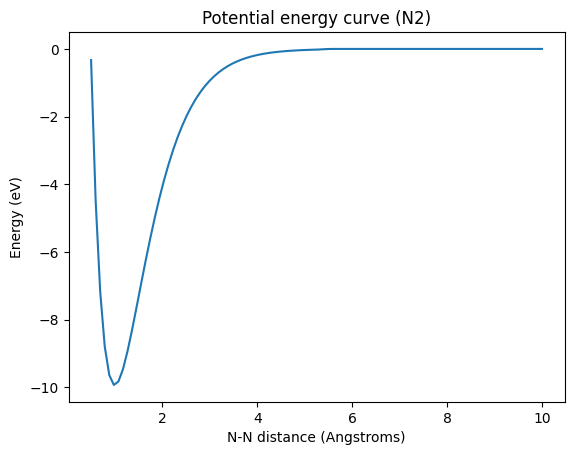

In [22]:
%matplotlib inline
from ase import Atoms
from ase.calculators.emt import EMT
from matplotlib import pyplot
import numpy as np


atom = Atoms('N', calculator=EMT())
e_atom = atom.get_potential_energy()

e = []
r = []
for d in np.linspace(.5,10,100):
    molecule = Atoms('2N', [(0., 0., 0.), (0., 0., d)])
    molecule.set_calculator(EMT())
    ei = molecule.get_potential_energy() - 2 *e_atom
    e.append(ei)
    r.append(d)

pyplot.plot(r ,e ,'-')
pyplot.xlabel("N-N distance (Angstroms)")
pyplot.ylabel("Energy (eV)")
pyplot.title("Potential energy curve (N2)")

# **Dinámica molecular**

In [23]:
from google.colab import output
output.enable_custom_widget_manager()

In [24]:
from ase.lattice.cubic import FaceCenteredCubic
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.verlet import VelocityVerlet
from ase import units
from ase.calculators.emt import EMT
from ase.constraints import FixCom
from ase.build import molecule
from ase.io import read
from ase.visualize import view
import warnings
warnings.filterwarnings("ignore")
from google.colab import output
output.enable_custom_widget_manager()

#size*size*size is the number of times the unit cell is repeated
size=2
# Set up the surface
atoms = FaceCenteredCubic(directions=[[1, 0, 0], [0, 1, 0], [0, 0, 1]],
                          symbol='Cu',
                          size=(size, size, size),
                          pbc=True)

# Describe the interatomic interactions with the Effective Medium Theory
atoms.set_calculator(EMT())


# Set the momenta corresponding to T=300K
MaxwellBoltzmannDistribution(atoms, 300 * units.kB)

c=FixCom()
atoms.set_constraint(c)
# We want to run MD with constant energy using the VelocityVerlet algorithm.
dyn = VelocityVerlet(atoms, 5 * units.fs, trajectory='md.traj')  # 5 fs time step.

# Now run the dynamics
dyn.run(100)
configs = read('md.traj@0:')
view(configs, viewer='ngl')

# **Ecuación de estado (sólidos)**
https://en.wikipedia.org/wiki/Murnaghan_equation_of_state

https://wiki.fysik.dtu.dk/ase/tutorials/eos/eos.html

<Axes: title={'center': 'sj: E: -0.000 eV, V: 16.781 Å$^3$, B: 100.142 GPa'}, xlabel='volume [Å$^3$]', ylabel='energy [eV]'>

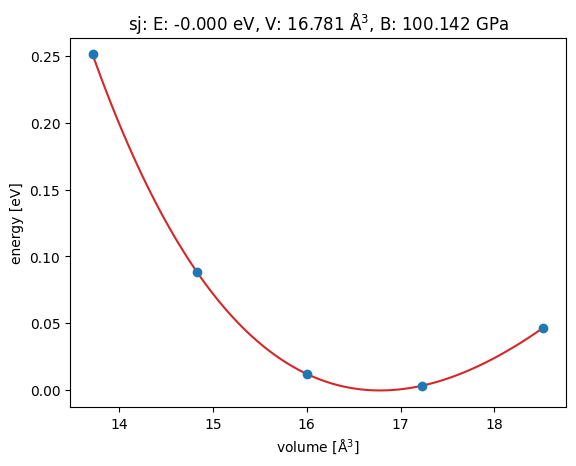

In [25]:
%matplotlib inline
import numpy as np

from ase import Atoms
from ase.io.trajectory import Trajectory
from ase.calculators.emt import EMT
from ase.io import read
from ase.units import kJ
from ase.eos import EquationOfState
from ase.visualize import view
import warnings
warnings.filterwarnings("ignore")

a = 4.0  # approximate lattice constant
b = a / 2
ag = Atoms('Ag',
           cell=[(0, b, b), (b, 0, b), (b, b, 0)],
           pbc=1,
           calculator=EMT())  # use EMT potential
cell = ag.get_cell()
traj = Trajectory('Ag.traj', 'w')
for x in np.linspace(0.95, 1.05, 5):
    ag.set_cell(cell * x, scale_atoms=True)
    ag.get_potential_energy()
    traj.write(ag)

configs = read('Ag.traj@0:5')  # read 5 configurations
# Extract volumes and energies:
volumes = [ag.get_volume() for ag in configs]
energies = [ag.get_potential_energy() for ag in configs]
eos = EquationOfState(volumes, energies)
v0, e0, B = eos.fit()
#print(B / kJ * 1.0e24, 'GPa')
eos.plot('Ag-eos.png')